# ARIMA Modeling with Python

In [57]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
 
#https://www.kaggle.com/rakannimer/air-passengers
df=pd.read_csv("AirPassengers.csv")
 
#We need to set the Month column as index and convert it into datetime
df.set_index('Month',inplace=True)
df.index=pd.to_datetime(df.index)
df.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

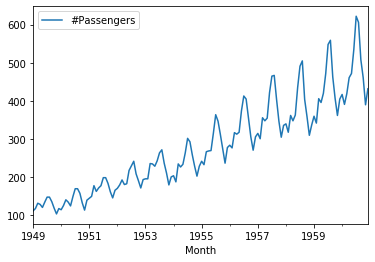

In [58]:
df.plot()

Dickie fuller test of unit root test (stationarity test)

In [59]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['#Passengers'])
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': 0.8153688792060543,
 'pvalue': 0.9918802434376411,
 'usedlag': 13,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 996.692930839019}

As expected we failed to reject the Null Hypothesis and the series has a unit root thus is not stationary.

## Transform series into stationary

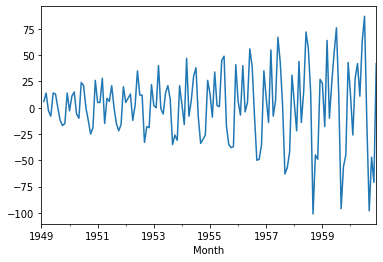

In [60]:
df['1difference']=df['#Passengers']-df['#Passengers'].shift(1)
df['1difference'].plot()

In [61]:
#note we are dropping na values because the first value of the first difference is NA
result=adfuller(df['1difference'].dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -2.8292668241700034,
 'pvalue': 0.054213290283824954,
 'usedlag': 12,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 988.5069317854084}

As you can see we fail to reject the null hypothesis because we have a p-value>0.05. That suggests that the series is not stationary and we need to use differencing again taking the second difference. The second difference can be computed as the first but this time instead of using the observations, we will use the first difference.

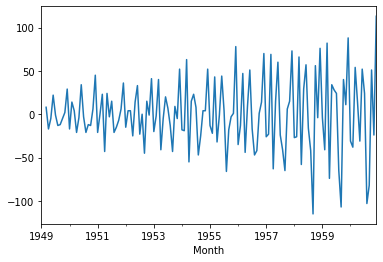

In [62]:
df['2difference']=df['1difference']-df['1difference'].shift(1)
df['2difference'].plot()

In [63]:
result=adfuller((df['2difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -16.384231542468488,
 'pvalue': 2.7328918500143186e-29,
 'usedlag': 11,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 988.6020417275604}

The p-value is less than 0.05 so we can reject the null hypothesis. That means the second difference is stationary and that suggests that a **good estimate for the value d is 2**

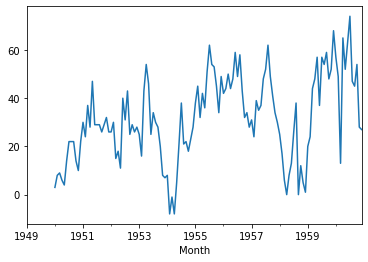

In [64]:
df['Seasonal_Difference']=df['#Passengers']-df['#Passengers'].shift(12)
ax=df['Seasonal_Difference'].plot()

In [65]:
result=adfuller((df['Seasonal_Difference']).dropna())
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

{'adf': -3.3830207264924805,
 'pvalue': 0.011551493085514982,
 'usedlag': 1,
 'nobs': 130,
 'criticalvalues': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'icbest': 919.527129208137}

**The p-value is less than 0.05** thus it’s stationary and we don’t have to use differencing. That suggests using 0 for the D value.

## Autocorrelation and partial autocorrelation (ACF and PACF)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


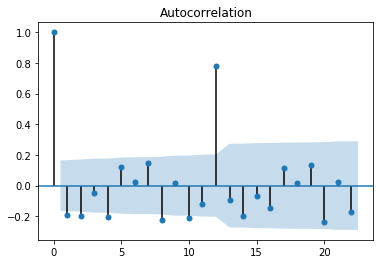

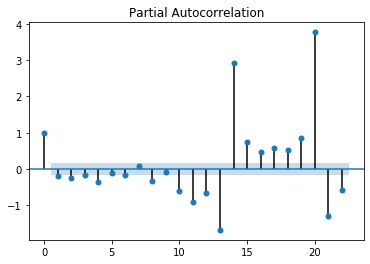

In [66]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(df['2difference'].dropna())
fig2=plot_pacf(df['2difference'].dropna())

We can see that we have a sharp cut-off at lag-1 in both of our plots. According to the rules we mentioned above, this suggests using an AR and MA term. In other words, p=1 and q=1.

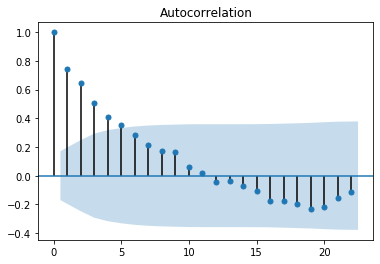

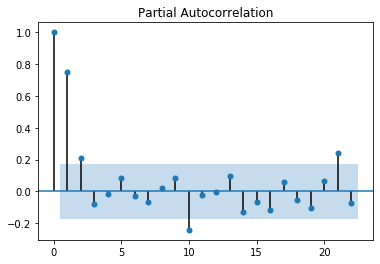

In [67]:
fig1=plot_acf(df['Seasonal_Difference'].dropna())
fig2=plot_pacf(df['Seasonal_Difference'].dropna())

We have a gradual decrease in the Autocorrelation plot and a sharp cut-off in the Partial Autocorrelation plot. This suggests using AR and not over the value of 1 for the seasonal part of the ARIMA.

## ARIMA Model

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df['#Passengers'],order=(1,2,1),seasonal_order=(1, 0, 0, 12))
result=model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plot residuals to check if they look normal

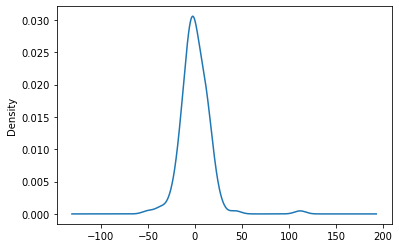

In [69]:
result.resid.plot(kind='kde')

Create future dates and forecast

In [70]:
from pandas.tseries.offsets import DateOffset
new_dates=[df.index[-1]+DateOffset(months=x) for x in range(1,48)]
df_pred=pd.DataFrame(index=new_dates,columns =df.columns)
df_pred.head()

#Passengers 1difference 2difference Seasonal_Difference
1961-01-01         NaN         NaN         NaN                 NaN
1961-02-01         NaN         NaN         NaN                 NaN
1961-03-01         NaN         NaN         NaN                 NaN
1961-04-01         NaN         NaN         NaN                 NaN
1961-05-01         NaN         NaN         NaN                 NaN

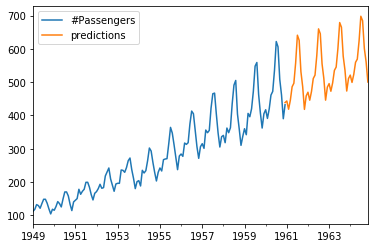

In [71]:
df2=pd.concat([df,df_pred])
df2['predictions']=result.predict(start=143,end=191)
df2[['#Passengers','predictions']].plot()

# ARIMA of Google Trends

In [28]:
data = pd.read_excel("series_risk.xlsx", sheet_name = "original")
data.set_index("Fecha", inplace = True)

## Plot Series

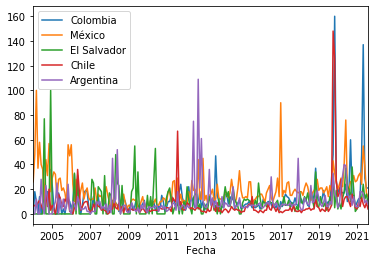

In [29]:
data.plot()

In [34]:
countries = list(data.columns)
countries

['Colombia', 'México', 'El Salvador', 'Chile', 'Argentina']

In [36]:
import matplotlib.pyplot as plt

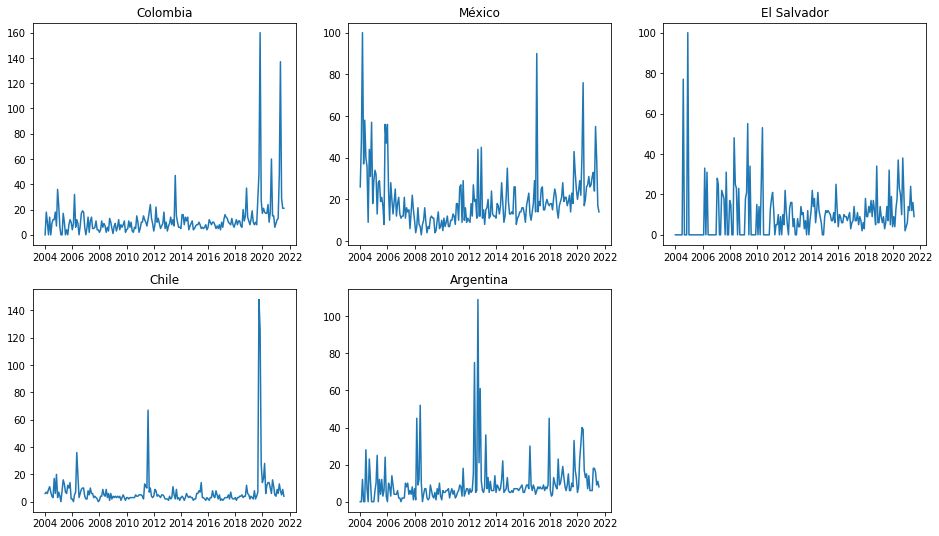

In [38]:
plt.figure(figsize=(16,9))
for i, country in enumerate(countries):
    plt.subplot(2,3,i+1)
    df = data[country]
    plt.plot(df)
    plt.title(country)

In [41]:
adfuller(data["Colombia"])

(-10.045244208432605,
 1.460278952433187e-17,
 0,
 211,
 {'1%': -3.46172743446274,
  '5%': -2.8753374677799957,
  '10%': -2.574124089081557},
 1624.6616133117654)

In [42]:
results = []
for country in countries:
    result = adfuller(data[country])
    dict_result = dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))
    p_value = dict_result['pvalue']
    results.append(p_value)
    
results

[1.460278952433187e-17,
 0.0035724622418905837,
 1.335488230550748e-10,
 9.21249567377193e-09,
 2.3471779560521656e-06]

Segun el test de dickie fuller todos son estacionarios

## Seasonal difference

In [53]:
for country in countries:
    data['SD_' + country]=data[country]-data[country].shift(12)

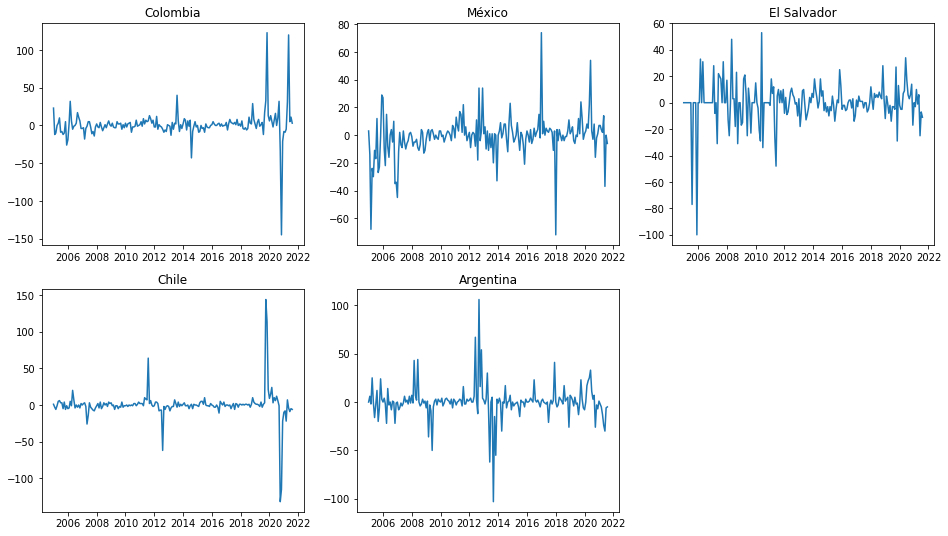

In [77]:
plt.figure(figsize=(16,9))
for i, country in enumerate(countries):
    plt.subplot(2,3,i+1)
    df = data["SD_"+country]
    plt.plot(df)
    plt.title(country)

In [75]:
results_sd = []
for country in countries:
    result = adfuller(data["SD_"+country].dropna())
    dict_result = dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))
    p_value = dict_result['pvalue']
    results_sd.append(p_value)
    
results

[1.460278952433187e-17,
 0.0035724622418905837,
 1.335488230550748e-10,
 9.21249567377193e-09,
 2.3471779560521656e-06]

## ACF & PACF

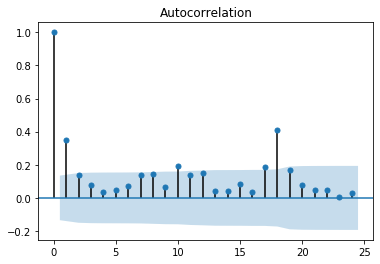

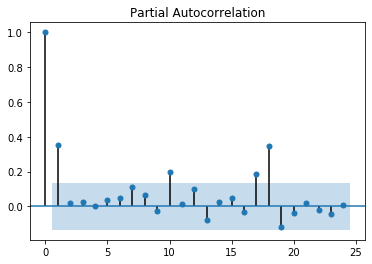

In [78]:
country = "Colombia"
fig1 = plot_acf(data[country].dropna())
fig2 = plot_pacf(data[country].dropna())
    

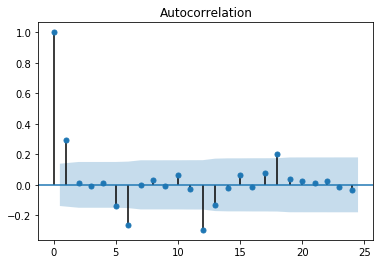

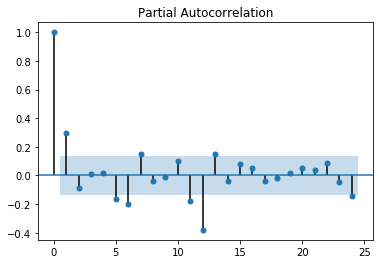

In [79]:
country = "Colombia"
fig1 = plot_acf(data["SD_"+country].dropna())
fig2 = plot_pacf(data["SD_"+country].dropna())

Colombia parece ARIMA (2,0,2) = AR(2) y MA(2) integrado de orden 0

In [86]:
model_col =SARIMAX(data["Colombia"],order=(2,0,2))
#model_col =SARIMAX(data["Colombia"],order=(2,0,2),seasonal_order=(1, 0, 0, 12))
result_col = model_col.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


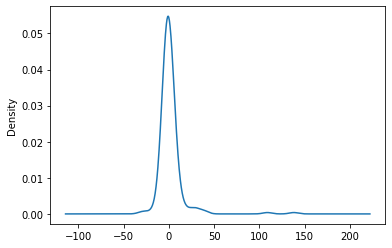

In [87]:
result_col.resid.plot(kind='kde')

In [108]:
! pip install pmdarima

  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:


ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acceso denegado: 'c:\\programdata\\anaconda3\\lib\\site-packages\\numpy\\compat\\py3k.py'
Consider using the `--user` option or check the permissions.



In [111]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
#adf_test = ADFTest(alpha = 0.05)
#adt_test.should_diff(data["Colombia"])

ModuleNotFoundError: No module named 'pmdarima'